In [95]:
from entrainment_metrics import InterPausalUnit
import json
from typing import List

In [96]:
session_number=1
raw_json = open("../corpus_with_time.json", "r")
corpus = json.load(raw_json)
session = corpus[str(session_number)]
audio_file = "../"+session["speech_filename"]

In [97]:

timestamps = [{'start':time[0]/1000 , 'end': time[1]/1000, 'speaker': session["spks"][i]} for i, time in enumerate(session["times"])]

# InterPausalUnitオブジェクトのリストを作成
ipus_speaker_ERICA: List[InterPausalUnit] = [InterPausalUnit(start=t['start'], end=t['end']) for t in timestamps if t['speaker'] == 'ERICA']
ipus_speaker_User: List[InterPausalUnit] = [InterPausalUnit(start=t['start'], end=t['end']) for t in timestamps if t['speaker'] == 'User']



In [112]:
# 各InterPausalUnitについて特徴量を計算
for ipu in ipus_speaker_ERICA:
    ipu.calculate_features(
        audio_file=audio_file,
        pitch_gender="F",  # 音声の性別に応じて "M" または "F" を使用
        extractor="speech-rate"
    )
    print(ipu.features_values)
    
for ipu in ipus_speaker_User:
    ipu.calculate_features(
        audio_file=audio_file,
        pitch_gender="F",  # 音声の性別に応じて "M" または "F" を使用
        extractor="praat"
    )

/Users/shusuke-k/Desktop/persuation_practice/entrainment/lib/python3.10/site-packages/allosaurus/am/utils.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_di

{'SECONDS': 1.1, 'F0_MAX': 339.034, 'F0_MIN': 261.443, 'F0_MEAN': 310.289, 'F0_MEDIAN': 318.902, 'F0_STDV': 21.104, 'F0_MAS': 329.661, 'ENG_MAX': 62.406, 'ENG_MIN': 31.681, 'ENG_MEAN': 43.192, 'ENG_STDV': 9.174, 'VCD2TOT_FRAMES': 0.542, 'speech_rate': 9.090909090909138}
{'SECONDS': 3.66, 'F0_MAX': 313.055, 'F0_MIN': 204.454, 'F0_MEAN': 263.217, 'F0_MEDIAN': 264.06, 'F0_STDV': 19.858, 'F0_MAS': 282.524, 'ENG_MAX': 61.596, 'ENG_MIN': 31.247, 'ENG_MEAN': 45.956, 'ENG_STDV': 9.079, 'VCD2TOT_FRAMES': 0.57, 'speech_rate': 13.93442622950821}
{'SECONDS': 3.23, 'F0_MAX': 392.142, 'F0_MIN': 194.864, 'F0_MEAN': 275.225, 'F0_MEDIAN': 261.207, 'F0_STDV': 44.584, 'F0_MAS': 368.781, 'ENG_MAX': 62.868, 'ENG_MIN': 30.905, 'ENG_MEAN': 45.546, 'ENG_STDV': 8.684, 'VCD2TOT_FRAMES': 0.569, 'speech_rate': 13.312693498452054}
{'SECONDS': 1.33, 'F0_MAX': 276.178, 'F0_MIN': 191.031, 'F0_MEAN': 237.8, 'F0_MEDIAN': 237.586, 'F0_STDV': 18.834, 'F0_MAS': 284.913, 'ENG_MAX': 57.026, 'ENG_MIN': 31.001, 'ENG_MEAN': 43

In [94]:
print(ipu.features_values)

{'SECONDS': 0.62, 'F0_MAX': 166.313, 'F0_MIN': 158.102, 'F0_MEAN': 162.529, 'F0_MEDIAN': 161.915, 'F0_STDV': 2.861, 'F0_MAS': 231.435, 'ENG_MAX': 47.243, 'ENG_MIN': 31.24, 'ENG_MEAN': 38.337, 'ENG_STDV': 5.829, 'VCD2TOT_FRAMES': 0.121}


In [105]:
from entrainment_metrics.tama import get_frames
from typing import List, Union
from entrainment_metrics import tama
from entrainment_metrics.tama import Frame, MissingFrame
from entrainment_metrics.tama import calculate_sample_correlation

In [102]:
frame_length = 16.0
time_step = 8.0

# フレームの生成
def create_frames(ipus: List[InterPausalUnit], frame_length: float, time_step: float) -> List[Union[Frame, MissingFrame]]:
    frames = []
    max_end_time = max(ipu.end for ipu in ipus)
    current_start = 0.0
    
    while current_start < max_end_time:
        current_end = current_start + frame_length
        frame_ipus = [ipu for ipu in ipus if ipu.start < current_end and ipu.end > current_start]
        
        if frame_ipus:
            frame = Frame(
                start=current_start,
                end=current_end,
                is_missing=False,
                interpausal_units=frame_ipus
            )
        else:
            frame = MissingFrame(start=current_start, end=current_end)
        
        frames.append(frame)
        current_start += time_step
    
    return frames

# フレームのリストを作成
frames_speaker_ERICA = create_frames(ipus_speaker_ERICA, frame_length, time_step)
frames_speaker_User = create_frames(ipus_speaker_User, frame_length, time_step)

In [59]:
from entrainment_metrics.tama import calculate_time_series
from typing import List

# 特徴量に基づいた時系列データの生成
time_series_ERICA: List[float] = calculate_time_series(
    feature='SECONDS',
    frames=frames_speaker_ERICA,
    audio_file=audio_file,
    extractor="praat",
    pitch_gender="F",
)
time_series_User: List[float] = calculate_time_series(
    feature='SECONDS',
    frames=frames_speaker_User,
    audio_file=audio_file,
    extractor="praat",
    pitch_gender="F",
)

In [69]:
from entrainment_metrics.tama import calculate_sample_correlation

# サンプルクロスコリレーションの計算
sample_cross_correlations: List[float] = calculate_sample_correlation(
    time_series_a=time_series_ERICA,
    time_series_b=time_series_User,
    lags=6,  # 適切なラグの数を指定
)

In [70]:
print(sample_cross_correlations)

[nan nan nan nan nan nan nan]


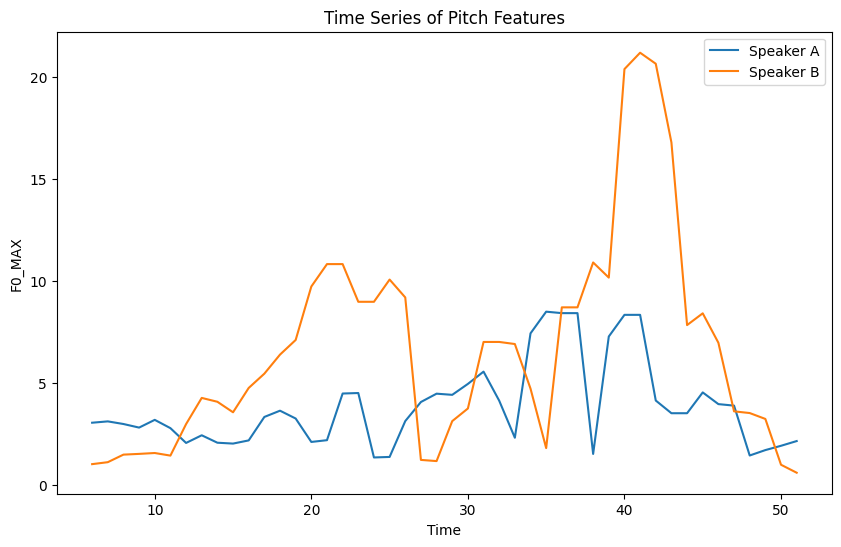

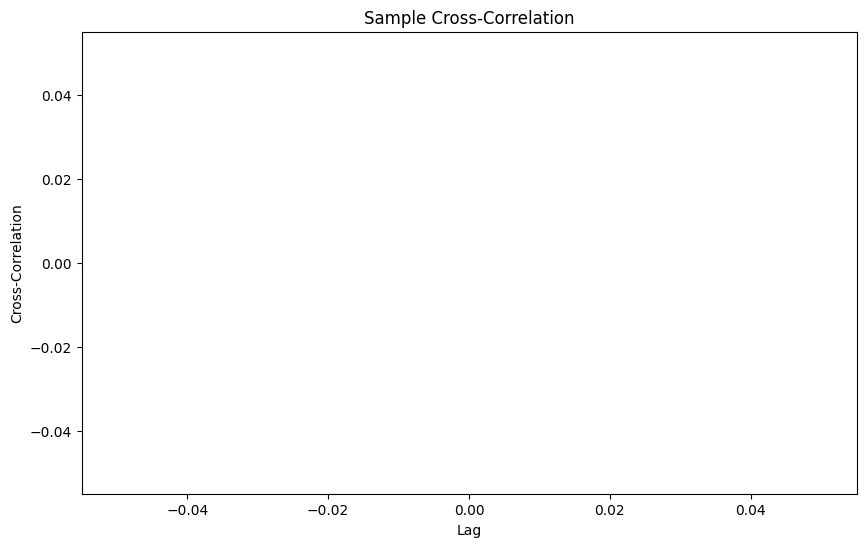

In [66]:
import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(10, 6))
plt.plot(time_series_ERICA, label='Speaker A')
plt.plot(time_series_User, label='Speaker B')
plt.title('Time Series of Pitch Features')
plt.xlabel('Time')
plt.ylabel('F0_MAX')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sample_cross_correlations)
plt.title('Sample Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.show()


In [108]:
from entrainment_metrics.continuous import TimeSeries

# 発話者AのTimeSeriesオブジェクトを作成
time_series_speaker_a = TimeSeries(
    interpausal_units=ipus_speaker_ERICA,
    feature="ENG_MAX",
    method='knn',  # 使用する補間方法
    k=8  # k-NNのパラメータ
)

# 発話者BのTimeSeriesオブジェクトを作成
time_series_speaker_b = TimeSeries(
    interpausal_units=ipus_speaker_User,
    feature="ENG_MAX",
    method='knn',
    k=8
)

In [111]:
sample_cross_correlations: List[float] = calculate_sample_correlation(
    time_series_a=time_series_ERICA,
    time_series_b=time_series_User,
    lags=6,  # 適切なラグの数を指定
)
print(sample_cross_correlations)

[nan nan nan nan nan nan nan]


In [86]:
from entrainment_metrics.continuous import calculate_metric

# Convergenceの計算
convergence_result = calculate_metric(
    metric="convergence",
    time_series_a=time_series_speaker_a,
    time_series_b=time_series_speaker_b
)

print("Convergence:", convergence_result)


Convergence: 0.4481193523752377


In [87]:
# Synchronyの計算
synchrony_result = calculate_metric(
    metric="synchrony",
    time_series_a=time_series_speaker_a,
    time_series_b=time_series_speaker_b
)

print("Synchrony:", synchrony_result)


Synchrony: -0.07465556666050323


In [88]:
# Synchronyの計算
synchrony_result = calculate_metric(
    metric="proximity",
    time_series_a=time_series_speaker_a,
    time_series_b=time_series_speaker_b
)

print("Synchrony:", synchrony_result)


Synchrony: -0.08878520934509737
